<img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 26th, 2025</h3> 
<h4 align="center">Day 2</h4> 

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> During the lecture, we learned about behavioral states and how they affect the processing of sensory stimuli and, consequently, motor outputs. In this workshop, we will explore how to define behavioral states and investigate both external and internal markers of state changes reflected through behavior as well as neural activity.

<p>  We will delve into advanced methodologies for defining behavioral states that will enable us to integrate multi-dimensional behavioral data. Throughout the workshop, we'll follow a gradual learning trajectory: starting with your grasp of clustering through K-Means, we will extend into more sophisticated probabilistic modeling with GMMs and finally culminate in the analysis of behavioral data using a state-space model—specifically, hidden Markov models.

</div>

In [1]:
# Standard library
import os  

# Data handling packages
import numpy as np  
import numpy.random as npr  
import pandas as pd 
import pynwb  

# Progress bar utility
from tqdm import tqdm  # Displays a smart progress bar during loops

# Preprocessing
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)

# Plotting libraries
import matplotlib.pyplot as plt  
from matplotlib import colors  
import seaborn as sns  

# Pandas display settings
pd.set_option('display.max_columns', None)  # Ensures all columns are shown when printing DataFrames

# Inline plotting for Jupyter Notebooks
%matplotlib inline  


 <div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">   
<p> To begin, let's start by reacquainting ourselves with the Visual Behavior dataset from workshop 1. However, this time we will explore their behavioral patterns.
</div>

In [2]:
# pick a session_id and get session data

example_session_ids = [1139846596, 1152811536, 1069461581 ]

# 664851_2023-11-13

session_id = example_session_ids[1]
nwb_path = f'/root/capsule/data/visual-behavior-neuropixels/behavior_ecephys_sessions/{session_id}/ecephys_session_{session_id}.nwb'

# access the session data with pynwb
session = pynwb.NWBHDF5IO(nwb_path).read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
# Quick reference of the NWB file structure
# Important groups include: units, trials, epochs, and processing 

session

Data type,float64
Shape,"(582647, 2)"
Array size,8.89 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(582647,)"
Array size,4.45 MiB
Chunk shape,None


In [4]:
trials = session.trials[:]

display(trials.head(20))



,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
id,,,,,,,,,,,,,,,,,,,,
0,27.56082,28.31102,im104_r,im104_r,False,NaN,False,False,[27.9937],NaN,NaN,0.000,False,False,False,False,True,False,-99,0.75020
1,28.31102,29.06198,im104_r,im104_r,False,NaN,False,False,[28.72716],NaN,NaN,0.000,False,False,False,False,True,False,-99,0.75096
2,29.06198,30.47927,im104_r,im104_r,False,NaN,False,False,[30.16227],NaN,NaN,0.000,False,False,False,False,True,False,-99,1.41729
3,30.56290,31.96406,im104_r,im104_r,False,NaN,False,False,[31.6468],NaN,NaN,0.000,False,False,False,False,True,False,-99,1.40116
4,32.06380,34.23226,im104_r,im104_r,False,NaN,False,False,[33.91533],NaN,NaN,0.000,False,False,False,False,True,False,-99,2.16846
5,34.31570,35.80034,im104_r,im104_r,False,NaN,False,False,[35.49996],NaN,NaN,0.000,False,False,False,False,True,False,-99,1.48464
6,35.81683,38.05249,im104_r,im104_r,False,NaN,False,False,[37.73522],NaN,NaN,0.000,False,False,False,False,True,False,-99,2.23566
7,38.06893,45.34175,im104_r,im005_r,True,41.07196,False,False,"[41.67132, 41.80486, 41.90495, 42.05505, 42.17...",41.67132,41.22212,0.005,False,False,False,False,False,True,870,7.27282
8,45.57509,49.22822,im005_r,im005_r,False,NaN,False,False,[48.91116],NaN,NaN,0.000,False,False,False,False,True,False,-99,3.65313


<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How well does the mouse recognize a change in the image sequences? We can quantify their performance by evaluating the fraction of 'go' trials during which the mouse licked the spout.      
</div>

In [5]:
num_go_trials = len(np.where(trials.go)[0])
num_go_hit_trials = len(np.where(trials.go[trials.hit])[0])
print('Proportion of trials correctly performed: ' + str(np.round(num_go_hit_trials/num_go_trials, 2)))

Proportion of trials correctly performed: 0.63


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.1:</b>  We have listed three example sessions here, access the metadata from each of the sessions. Print the proportion of 'go' trials that the mouse performed correctly and evaluate their mean performance. (Note: session = get_session(session_id) will take a minute or two to load the session))
</div>

<div style="background:rgb(240, 230, 216); border-radius: 3px; padding: 10px;">
Note: Please be wary while naming variables. Do not use variable names that are already assigned. Preferably, append the number corresponding to the example you are analyzing as we have done below. For example, if analyzing example mouse 2, use num_go_trials_2, etc.

In [6]:
# Blank coding cell to work out Task 1.1  

# Here, we have included the code to load the data from the other example mice.
#session_2 =  cache.get_ecephys_session(example_sessions[1])
#trial_metadata_2 = session_2.trials

#session_3 =  cache.get_ecephys_session(example_sessions[2])
#trial_metadata_3 = session_3.trials

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Looks like these mice fail to respond in about 20-50% of the trials!

<p> Next, we will their plot licking patterns for each 'go' trial to get a sense of when they are failing to respond.
</div>

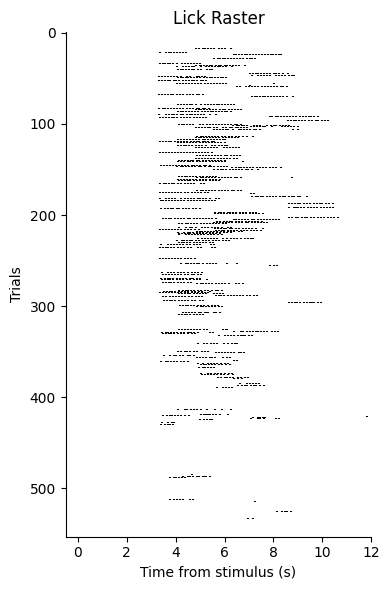

In [7]:
# Get 'go'trial numbers
go_trials = trials[trials.go]

# Get lick times for each 'go' trial. Note: we subtract the trial start time so lick times are relative to trial start
lick_times = go_trials.lick_times.values - go_trials.start_time.values



# Plot with eventplot
fig, ax = plt.subplots(figsize=(4, 6))
ax.eventplot(lick_times, orientation='horizontal', colors='black', linelengths=0.8, lineoffsets = go_trials.index)

# formatting 
ax.set_xlabel('Time from stimulus (s)')
ax.set_ylabel('Trials')
ax.set_title('Lick Raster')
ax.set_ylim(-0.5, go_trials.index[-1]+4)
ax.set_xlim(-0.5, 12)
plt.gca().invert_yaxis()  # Trial 0 at top
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

# add line to show stimulus presentation

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Interestingly, this mouse licks on many 'go' trials during the first part of the session but then rarely licks during the later trials.
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.2:</b> Plot lick rasters for the other example mice. What do their lick trends look like?
</div>

In [8]:
# Blank coding cell to work out Task 1.2  
# hint: use "trial_metadata_2" and "trial_metadata_3"

# lick_times2 = 

# fig, ax = plt.subplots(figsize = (5, 5))
# ax.eventplot(lick_times2, linelength = 1.5);

# # Add labels to plot
# ax.set_ylim(-0.5, len(lick_times2))
# ax.set_xlim(-0.5, 12)
# ax.set_ylabel('go trials')
# ax.set_xlabel('time (s)')
# ax.set_title("Lick raster for all 'go' trials")
# plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> So, these mice seem to stop responding during the later trials in the session. Another way of looking at this data is to plot the number of licks in each trial. 
</div>

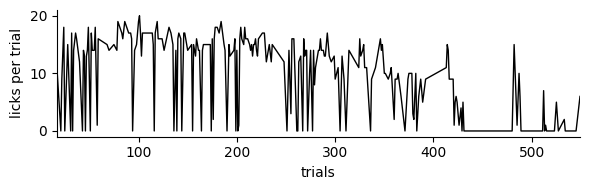

In [9]:
# Same plot as above, but only for 'go' trials
fig, ax = plt.subplots(figsize = (6, 2))

# Select 'go' trials
lick_count = go_trials.apply(lambda row : len(row['lick_times']), axis = 1)

# Plot lick rate
ax.plot(lick_count, color='k', lw = 1)

# Formatting
ax.set_ylabel('licks per trial')
ax.set_xlabel('trials')
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Could the mouse be disengaging from the task as they reach the end of the session? The reduction in licking seems to indicate this. 
<p> We can quantify their performance by computing the hit rate over the behavioral session. Hit rate is the probability the mouse correctly performs a lick during 'go' trials. Here, we will evaluate this as the fraction, over 10 go-trials, in which the mouse licked correctly to the image change.
    
</div>

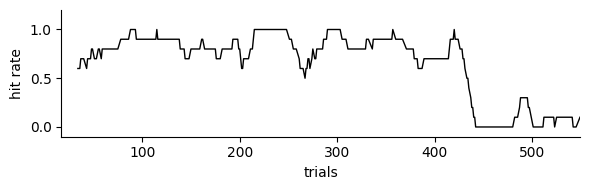

In [10]:
# Compute hit rate with 10 trial rolling window.
hit_rate = go_trials.hit.rolling(10).mean()

fig,ax = plt.subplots(figsize = (6, 2)) 
ax.plot(go_trials.index, hit_rate, color = 'k', lw = 1)

# Formatting
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We see that the hit rate is very high during the first 400 trials, then drops to zero around trial 500. Thus, the mouse is clearly "task engaged" during the first part of the session, but then becomes "task disengaged". Using this insight we can set an  threshold on hit rate to define engaged and disengaged states. What's a good threshold to set? 
</div>

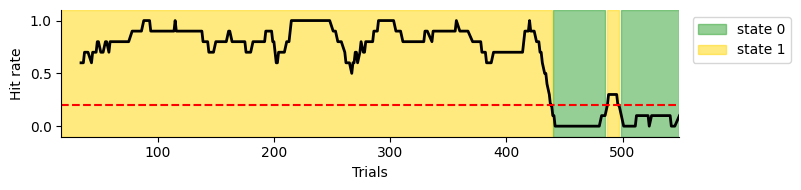

In [11]:
# Threshold for defining engageded vs disengaged states
engagement_threshold = 0.2

fig,ax = plt.subplots(figsize = (8.2, 2)) 
ax.plot(go_trials.index, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials.index, engagement_threshold*np.ones(num_go_trials), color = 'r', ls = '--')

# Determine state transition boundaries
states = hit_rate < engagement_threshold
ax.fill_between(states.index, -0.1, 1.1, where = states == 1, alpha=0.5, color = 'tab:green', label = 'state 0')
ax.fill_between(states.index, -0.1, 1.1, where = states == 0, alpha=0.5, color = 'gold', label = 'state 1')

# Formatting
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(go_trials.index[0], go_trials.index[-1])
ax.set_xlabel('Trials')
ax.set_ylabel('Hit rate')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> When the mouse’s cognitive state changes, does it affect other aspects of its behavior too? To answer this, let’s look beyond their lick patterns and examine additional variables—such as running speed, pupil size, and facial movements—that might also reflect these changes in behavioral state. </p>

</div>

### can we potentially do facial expressions? 

In [12]:
# Get timestamps corresponding to go trials
trial_start = go_trials.start_time
trial_stop = go_trials.stop_time

# initialize data dictionary
behavior_data = {}

In [13]:
# Get running speed and corresponding timestamps
running_data = session.processing['running']
running_timestamps = running_data['speed'].timestamps[:]
running_speed = running_data['speed'].data[:]
running_speed = pd.Series(running_speed).interpolate(limit_direction='both').to_numpy() 
behavior_data['running_speed']  = [np.nanmean(running_speed[np.logical_and(s1 <= running_timestamps, running_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]


# Get pupil area and corresponding timestamps
pupil_data = session.acquisition['EyeTracking']['pupil_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.area[:]
pupil_area = pd.Series(pupil_area).interpolate(limit_direction='both').to_numpy() 
behavior_data['pupil_area'] = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_timestamps, pupil_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]


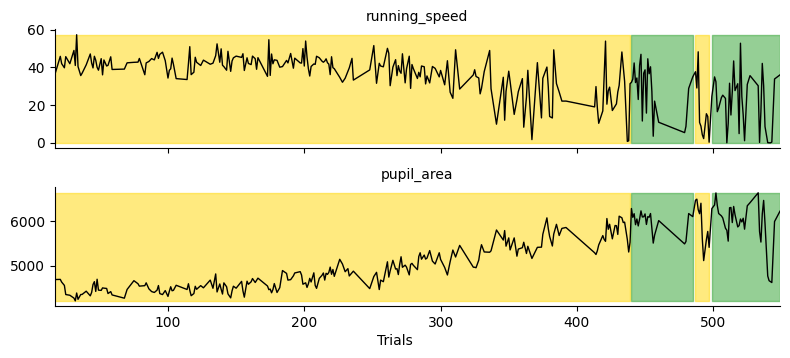

In [14]:
keys_to_plot = ['running_speed', 'pupil_area']

fig, ax = plt.subplots(len(keys_to_plot), 1, figsize = (8, 3.5), sharex = True)

for i, key in enumerate(keys_to_plot):
    ax[i].plot(go_trials.index, behavior_data[key], color = 'k', lw = 1)
    ax[i].set_title(key, fontsize = 10)
    
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    # Get min and max of this behavior trace
    min_val = np.nanmin(behavior_data[key])
    max_val = np.nanmax(behavior_data[key])

    # Fill between min*vis_context and max*vis_context
    ax[i].fill_between(states.index, min_val, max_val, where = states == 1, alpha=0.5, color = 'tab:green')
    ax[i].fill_between(states.index, min_val, max_val, where = states == 0, alpha=0.5, color = 'gold')

    ax[i].set_xlim(go_trials.index[0], go_trials.index[-1])

fig.text(0.5, 0.00, 'Trials', ha='center')
plt.tight_layout()


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets also add lick counts into our dictionary for behavior variables and convert it into a dataframe for easy visualization. 
</p> </div>

In [15]:
behavior_data['lick_count'] = lick_count 
behavior_df = pd.DataFrame(behavior_data)

behavior_df.head(10)

,running_speed,pupil_area,lick_count
id,,,
17,36.216381,4694.294483,11
21,45.886774,4697.555920,0
22,42.021054,4637.295625,9
24,39.827833,4562.832726,18
25,45.743499,4358.137253,0
28,41.987653,4341.882977,15
31,49.024156,4278.672856,0
32,41.052220,4215.719521,17
33,57.359513,4392.206372,0


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.4:</b> Can you evaluate the correlation between any two of these behavior variables of your interest? (Hint: scatter plot!)
</p> </div>

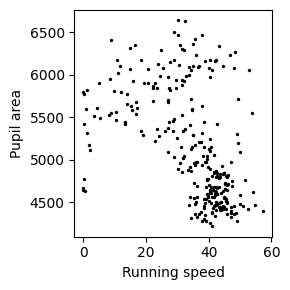

In [16]:
fig, ax = plt.subplots(figsize = (3, 3))
ax.scatter(behavior_data['running_speed'], behavior_data['pupil_area'], color = 'k', s= 2)
ax.set_xlabel("Running speed")
ax.set_ylabel("Pupil area")
plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> While defining states by thresholding the hit rate is a useful starting point, it is incomple Clearly, there are several additional variables that could provide more nuanced insights into the mouse’s behavioral states.. Yet we have not incorporated these signals into our definition of behavioral states. </p>

<p>Moreover, the threshold we used to define behavioral states appeared appropriate for the mouse we studied but may not generalize across animals. How, then, can we systematically assess state changes across many mice?</p>

<p>In the remainder of this workshop, we will explore more sophisticated methods for defining behavioral states that integrate multiple behavioral signals to provide a richer, more reliable description of each mouse’s cognitive and behavioral profile.</p>
</div>


<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> First, we'll learn how to make sense of a more complex view of the behavioral information. Instead of looking at just one behavior profile, we will examine multiple variables simultaneously to gain a better understanding of what's going on. As we have seen, some of these behavior variables correlate with the behavioral state and implicitly among themselves. Let's create a visualization to see how the different behavioral variables are correlated.

</div>

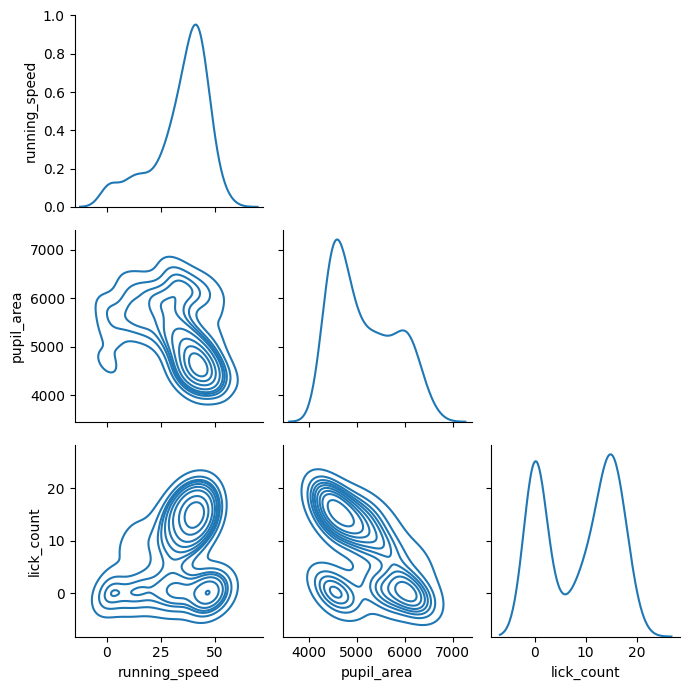

In [17]:
def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)

# Set layout for pairwise plot - 4 X 4 plot grid
g = sns.PairGrid(behavior_df,  vars=['running_speed', 'pupil_area', 'lick_count'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
width = "scott"
# *** Play around with the width of the density kernel. 
#     You can use float values between 0.1 to 1.  ****

g.map_lower(sns.kdeplot, hue=None, bw_method = width)

# Hide the upper triangle 
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = width)

# Formatting 
g.fig.set_size_inches(7,7)
g.fig.tight_layout()

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"> 
<p><b>Task 1.5: </b> In the pairwise density plots, try playing around with the option 'bw_method' by setting it to scalar values between [0.2, 1]. How does this effect the density plots? Do you still think there are only 2 states? Do this above. 
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> This visualization broadly showed two states that mapped well to our previous state definitions. But playing around with the density plots may have raised some doubts. </p>
    
<p> Does every peak deserve a behavior state? How can we define state boundaries while incorporating all behavior variables? Are there other behavior states? </p>

<p> Moreover, when determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. How do we incorporate time information?! </p>

<p> Lets break the problem into two parts: first, lets find out how we can incorporate a multivariate definition of behavioral states. Next, we will address the problem of incorporating time. 
    
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Multivariate definition of behavioral states</h4>

<p>The density plots suggest there may be multiple underlying behavioral states. One approach to identifying these states is to use unsupervised clustering methods to group similar observations across multiple behavioral variables, revealing distinct patterns that may correspond to different states.</p>

<p>K-means and Gaussian Mixture Models (GMMs) are two such clustering methods. While K-means assigns each data point to a single cluster with a deterministic assignment, GMMs allow data points to belong to multiple clusters with varying degrees of membership probabilities, making them more flexible than K-means. Unlike K-means, GMMs can model clusters with different shapes and orientations, providing a more realistic representation of the underlying structure.</p>

<p>Let’s see how we can draw a link from K-means clustering to GMMs. By making this connection, we will introduce a new tool to your toolbox: the concept of a mixture model, which seeks to maximize the likelihood of the observed data under a combination of probability distributions.</p>
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> K-means and Gaussian Mixture Models</h3>
    
<p> First, lets sort out our notation: 
<br> <b> Constants</b> 
    <ul>
        <li>$N$ - number of data points. </li>
        <li>$K$ - number of clusters/components </li>
    </ul>

<b> Data</b> 
    <ul>
        <li> $\mathbf{X} = \{x_{n}\}_{n=1}^N$ where $x_n \in \mathbb{R}^{D}$ is the $n^{th}$ data point </li>
    </ul>
    
<b> Latent Variables </b> 
    <ul>
        <li>$\mathbf{Z} = \{z_{n}\}_{n=1}^N$ wher $z_n \in \{1, ..., K\}$ is the cluster assignment for the $n^{th}$ data point </li>
    </ul>
    
<b> Parameters</b>   
    <ul> 
        <li> $\boldsymbol{\Theta} = \{\mu_k\}_{k=1}^K$ where $\mu_k \in \mathbb{R}^D$ is the mean of the $k$-th cluster </li>
    </ul>
    
<h4>K-Means</h4>
    K-Means is an algorithm for estimating the latent variables, $\mathbf{Z}$, and the parameters, $\boldsymbol{\Theta}$, given the data, $\mathbf{X}$. The algorithm alternates between two steps,
    <ol>
        <li><b>Assign</b> each data point to the closest cluster:
            \begin{align}
            z_{n} = \underset{k \in \{1,..., K\}}{\text{arg min}} || x_{n} - \mu_{k}||_{2}
            \end{align}
        </li>
        <li><b>Update</b> the parameters to the mean of the assigned data points
            \begin{align}
            \mu_{k} = \frac{1}{N_{k}}\sum_{n = 1}^{K} w_{n,k} x_{n}, 
            \end{align}
            where 
            \begin{align}
            w_{n,k} &= \begin{cases} 1 & \text{if } z_n =k \\ 0 & \text{o/w} \end{cases} \\
            N_k &= \sum_{n=1}^{N} w_{n,k}.
            \end{align}
        </li>
    </ol>
    

We can think of $w_{n,k}$ as the <i>weight</i> or <i>responsibility</i> that data point $n$ assigns to cluster $k$. 
<br>
</div>

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Question:</b> From this perspective, isn't it weird that K-Means assigns all the weight to the nearest cluster, even for points that are right on the boundary between two clusters? 
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4>Expectation-Maximization (EM)</h4>
Instead, consider the following tweak to K-Means. Instead of setting the weight to 0 or 1, set it to,
\begin{align}
    w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, I)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, I)}
\end{align}
where $\mathcal{N}(x \mid \mu, \Sigma)$ denotes the <b>probability density function (pdf)</b> of a point $x_n$ under a <b>multivariate normal distribution</b> with mean $\mu$ and covariance $\Sigma$.
<br>
Then the resulting algorithm corresponds to the expectation-maximization (EM) algorithm. EM is a generic algorithm of estimating the parameters of latent variable models. In this case, it estimates the parameters $\boldsymbol{\Theta}$ of a Gaussian mixture model.


<h4>Gaussian Mixture Model (GMM)</h4>
A GMM is a probabilistic model that specifies a joint distribution over data and latent variables given parameters, 
\begin{align}
    p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta}) 
    &= \prod_{n=1}^N p(x_n \mid z_n, \boldsymbol{\Theta}) \, p(z_n \mid \boldsymbol{\Theta}) \\
    &= \prod_{n=1}^N \mathcal{N}(x_n \mid \mu_{z_n}, I) \, \mathrm{Cat}(z_n \mid \tfrac{1}{K} \boldsymbol{1}_K)
\end{align}
It is a <b>generative model</b> in that we can sample latent variables and data points from the model. In one dimension, it looks like this:
<center><img src="../code/Resources/GMM.png" width="400" height="500" > </center>
<p>    
The nice thing about thinking in terms of generative models is that it allows us to extend the model in various ways. For example, 
    <ol>
        <li>We can let the clusters have <b>anisotropic covariance matrices</b> by changing the model to, 
        \begin{align}
            p(x_n \mid z_n, \boldsymbol{\Theta})
            &= \mathcal{N}(x_n \mid \mu_{z_n}, \Sigma_{z_n})
        \end{align}
        where now the parameter set consists of both means and covariance matrices, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k\}_{k=1}^K$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \Sigma_j &= \frac{1}{N_k} \sum_{n=1}^N w_{n,k} (x_n - \mu_k) (x_n - \mu_k)^\top
        \end{align*}
        </li>
        <li>We can allow for unbalanced classes by changing the model to,
        \begin{align}
            p(z_n \mid \boldsymbol{\Theta})
            &= \mathrm{Cat}(z_n \mid \boldsymbol{\pi})
        \end{align}
        where now the parameter set includes cluster probabilities, $\boldsymbol{\Theta} = \{\mu_k, \Sigma_k, \pi_k\}_{k=1}^K$ such that $\sum_k \pi_k = 1$. 
        <br>
        Then the assignment and update steps change to,
        \begin{align*}
            w_{n,k} &= \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \Sigma_j)} \\
            \pi_k &= \frac{N_k}{N}
        \end{align*}
        </li>
    </ol>
    
<h4>What are K-Means and EM really doing?</h4>
From this probabilistic perspective, we can now understand K-Means and EM as two closely related estimation algorithms. It turns out that K-Means is doing coordinate ascent on the joint probability, $p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$, alternating between assigning data points to clusters and updating the parameters. By contrast, EM is performing coordinate ascent on a <i>lower bound</i> on the marginal probability, $p(\mathbf{X} \mid \boldsymbol{\Theta}) = \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\Theta})$. 
    
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Next, let us take a brief moment to explore the sklearn Gaussian mixture models implementation to see how this generalization can be discussed in code.
</div>

<div style="border-left: 3px solid #000; border-radius: 3px;  padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> How should we incorporate time? </h2>
<p> But its not simply enough to fit a Gaussian distribution to our behavioral data. While GMMs are a powerful tool for clustering and learning probabilistic associations in our data,they assume that each data point is independent of others. When determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. A choice which fulfills the goal are state-space models. 
    
<p> State space models are a framework used to understand and predict complex systems that change over time. They are particularly useful when dealing with dynamic processes that might not be directly observable but can still influence the observed data. Sound familiar? 
    
<p> The state-space model that we will be exploring in this workshop is the Gaussian hidden Markov model (HMM). 

</div>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Gaussian Hidden Markov Model (HMM) </h4>
<p> A Gaussian HMM introduces the notion of dynamics to state determination. The behavior of an HMM is fully determined by three probabilties: 
  
<ol>
    <li> <b> Transition probability</b> $p(z_{t+1} \mid z_{t})$, the probability of $z_{t+1}$ given its previous state $z_t$.  We can describe the transition probability by a K $\times$ K matrix which is called transition matrix. The $(i,j)^{th}$ element of the matrix denotes the probability of the state transiting from the state $i$ to state $j$.
    </li>
    <li> <b> Emission probability </b> $p(x_{t}\mid z_{t})$, the probability of the observation $x_{t}$ given its hidden state $z_{t}$. Specifically, for a Gaussian HMM, emission probabilties take the following form, 
    \begin{align}
    p(x_t \mid z_t, \boldsymbol{\Theta}) &= \mathcal{N}(x_t \mid \mu_{z_t}, \Sigma_{z_t})
    \end{align}
    where the emission parameters $\boldsymbol{\Theta} = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.
    </li>
    <li> <b> Initial state distribution </b> $p(z_{1})$ 
    </li>
</ol>
</div>

<h4 align="left">Hidden Markov models</h4> 

<center><img src="../code/Resources/gHMM.png" width="300" height="400"> </center>

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>So, lets try out HMM models! First, let's take a moment to import our minmal set of packages. This might take a few minutes. 
    
<ul> Dynamax is a package created in collaboration between the Linderman lab and Google building around a JAX engine. JAX is a functional language which handles the backend for fast computation while presenting similarly to numpy. This means that you'll want to carry state along between calls. 
  
<p> Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). It also includes prior distributions on the parameters.

</div>

In [18]:
# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Additional HMM variants and plotting utilities from Dynamax
from dynamax.hidden_markov_model import (
    DiagonalGaussianHMM,
    SphericalGaussianHMM,
    SharedCovarianceGaussianHMM
)

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.6: </b> As we discuss these helper functions below, add to the docstring a comment about when you should use each of these helper functions. 
</div>

In [19]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

<div style="border-left: 3px solid #000;  border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Before we apply HMMs to real data, let's start with using Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [20]:
# Set up training parameters
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Set the transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Set the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))
  
# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Separating data into batches
train_key = jr.split(jr.PRNGKey(0), 3)
train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
for k in range(num_train_batches):
    train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps)


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets visualize how the HMM was modeled. For this, we can plot the 2D-data, and superimpose each states' Gaussian fit. 
</div>

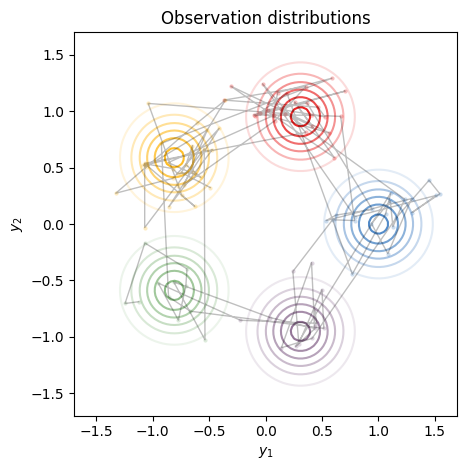

In [21]:
# Plot emissions and true_states 
plot_gaussian_hmm(hmm, true_params, train_observations[0], train_true_states[0], 
                  title="Observation distributions")

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.6: </b> How does the HMM data change as you alter the transition matrix? How does it change when you alter the emission variance? You can also try to play with the initial state distribution. 
</div>

In [22]:
"""
Starter code for you to change these parameters for task 1.7

# Set up training parameters
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Set the transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Set the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))
  
# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Set up training, validation, and test datasets
train_key = jr.split(jr.PRNGKey(0), 3)
train_true_states = np.zeros((num_train_batches, num_timesteps)).astype(int)
train_observations = np.zeros((num_train_batches, num_timesteps,  observations_dim))
for k in range(num_train_batches):
    train_true_states[k], train_observations[k] = hmm.sample(key = train_key[k], params=true_params, num_timesteps=num_timesteps)

"""

print('')

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> By plotting these states as a function of time, the interplay between descrete latent states, transition matrix mediated dynamics (Markov process) and the observations (or emissions) becomes more clear.
</div>

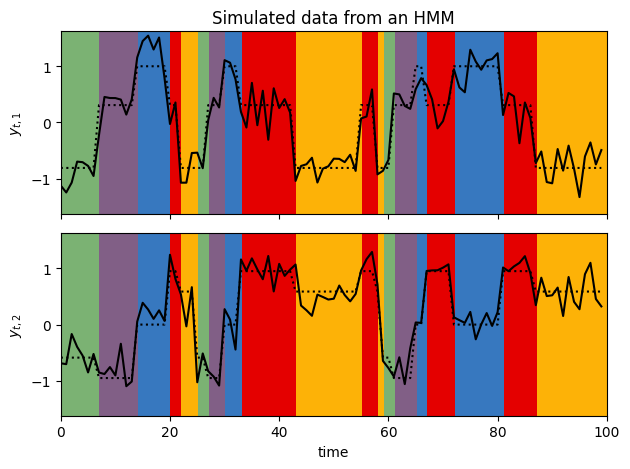

In [23]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0])

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.
    
<p> This function fits the data into _folds_ where each fold consists of all but one of the training sequences. It fits the model to each fold in  parallel, and then computs the log likelihood of the held-out sequence for each fold. The average held-out log likelihood is what we will use for determining the number of discrete states.
</div>


In [24]:
def cross_validate_model(model, key, num_iters=100):
    
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method='kmeans', emissions=train_observations)
    
    # Split the training data into folds.
    folds = jnp.stack([
        jnp.concatenate([train_observations[:i], train_observations[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        # Funtion to fit the HMM
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)
    
    val_lls = np.zeros(num_train_batches)
    for k in range(num_train_batches): 
        y_val = train_observations[k]
        y_train = train_observations[list(set(np.arange(num_train_batches))  - set([k]))]
        # print(f.shape, train_observations.shape)
        val_lls[k] = _fit_fold(y_train, y_val)
        
    return val_lls.mean(), val_lls

In [25]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, observations_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []


for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.7:</b>  Plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

In [26]:
# Blank coding cell to work out Task 2.1

# plt.figure(figsize = (4, 3))
# plt.plot
# for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
#     plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
# plt.xlabel("num states ($K$)")
# plt.ylabel("avg. validation log prob.")
# plt.tight_layout()

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> How should we choose the right number of states? 
    
<p> There's no single "right" answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
<p> * picking $K$ consistent with the predicability-computability-stability (PCS) framework.
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


In [27]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5


<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now let's fit our model with the best number of states. Using the number of states with the highest loglikelihood average, we can fit our Gaussian HMM.
</div>

In [28]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, observations_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_observations)
params, lps = test_hmm.fit_em(params, props, train_observations, num_iters=100)

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.8:</b>  Plot up the log-likelihood and compare it to the actual lp.
</div>

In [29]:
# Helper code for task 2.5

# Evaluate the log probability of the training data under the true parameters

# Plot log probs vs num_iterations for task 2.5

<div style="background: rgb(32, 177, 13); border-radius: 3px; padding: 10px; color: white;"">
<p><b>Task 1.10:</b>  Compare the inferred states to the actual states by using the plot_gaussian_hmm_data() method for both the inferred and actual states. Discuss with your neighbors what you observe and if you can spot any errors.
    
<p> If you finish early, please consider which of the features of this data would make it more difficult to reconstruct and what you might expect the failure to look like. What would happen if you choose too many states? Too few?
    
<p> hint:  use the method: hmm.most_likely_states(params, observations)    
</div>

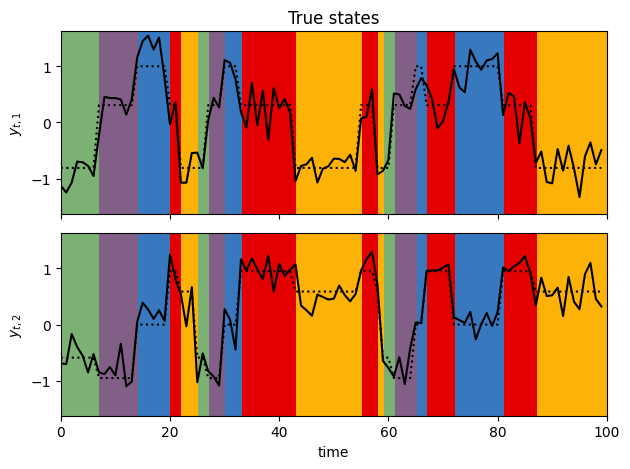

In [30]:
# helper code for task 2.6

plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0], title = 'True states')

# Get inferred states

<div style="border-left: 3px solid #000; border-radius: 3px; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> State determination in Visual Behavior Neuropixels data </h3>
<p> We now kind of get a hang of HMM. So, let's take what we've done above and apply it to the behavior variables from the previous workshop to automatically detect states in our mice! Now, we have the capability to incorporate a multi-dimensional dataset to inform our state boundaries. 
<p> To accomplish this goal, we will fit our data to a Gaussian HMM. 
    
<p> To complement our states from the previous workshop, lets extract the behavior states using only behavior data, that is, pupil size, running speed and lick counts.
</div>

In [31]:
# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array(behavior_df.values)
num_trials, num_dimensions = observations.shape

# First scale the dimensions of the data to be normalized
scaler = StandardScaler()    
observations = scaler.fit_transform(observations)

# Split the data into equal length batches for cross-validation
n_batches = 6
n_steps = num_trials - (num_trials % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

In [32]:

# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []

key = jr.PRNGKey(0)
num_states_range = np.arange(1, 9)
# Run a loop to fit the data to a range of states
for num_states in num_states_range:
    print(f"\n{'='*40}\nTraining model with {num_states} state(s)\n{'='*40}")

    test_log_probs = []
    
    predicted_states = np.zeros([num_trials, n_batches], dtype = int)
    
    for batch in range(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        if num_states == 1:
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,num_dimensions])
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])    #scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, num_dimensions, transition_matrix_stickiness=10.)
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)

    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))    


Training model with 1 state(s)



Training model with 2 state(s)



Training model with 3 state(s)



Training model with 4 state(s)



Training model with 5 state(s)



Training model with 6 state(s)



Training model with 7 state(s)



Training model with 8 state(s)


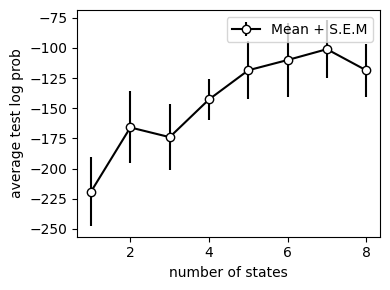

In [33]:
plt.figure(figsize = (4, 3))
plt.errorbar(num_states_range, avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(num_states_range, all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [57]:
key = jr.PRNGKey(0)
best_num_states = 4
number_of_states = best_num_states 
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=1)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)


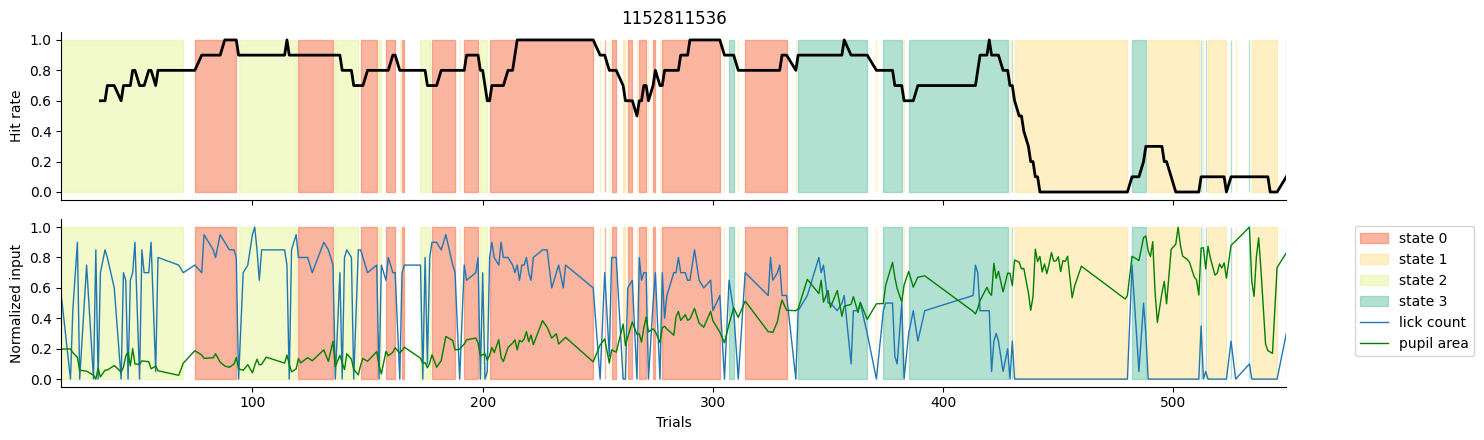

In [58]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 


# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(2, 1, figsize=(15, 4.5), sharex=True)
cmap =sns.color_palette("Spectral", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
hmm_states = most_likely_states
ax[0].plot(go_trials.index, hit_rate, color = 'k', lw = 2)
for i in range(2): 
    for state_id in range(best_num_states): 
        # Fill between min*vis_context and max*vis_context
        ax[i].fill_between(go_trials.index, 0, 1, where = hmm_states == state_id,
        alpha=0.5, color = cmap[state_id], ls = 'None', label = f'state {state_id}')


# Overlay behavioral variables 
ax[1].plot(behavior_df.index, minmax(behavior_df['lick_count']), color = 'tab:blue', label="lick count", lw = 1)
ax[1].plot(behavior_df.index, minmax(behavior_df['pupil_area']), color = 'green', label="pupil area", lw = 1)

# Formatting 

ax[0].set_title(f'{session_id}')
ax[0].set_ylabel("Hit rate")
ax[1].set_xlabel("Trials")

ax[1].set_ylabel('Normalized input')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)


for j in range(2): 
    ax[j].set_xlim(go_trials.index[0], go_trials.index[-1])
    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)


plt.tight_layout()

In [ ]:
len(trials) - len(go_trials)


261

In [60]:
np.sum(hmm_states == 2)

Array(63, dtype=int32)

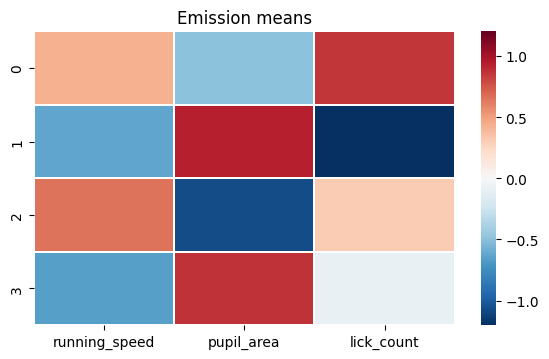

In [63]:
plt.figure(figsize = (5.8, 3.7))
sns.heatmap(params.emissions.means, xticklabels = behavior_df.keys(), yticklabels= np.arange(number_of_states), cmap = 'RdBu_r', linewidths=0.2, vmax = 1.2, vmin = -1.2)
plt.title('Emission means')
plt.tight_layout()

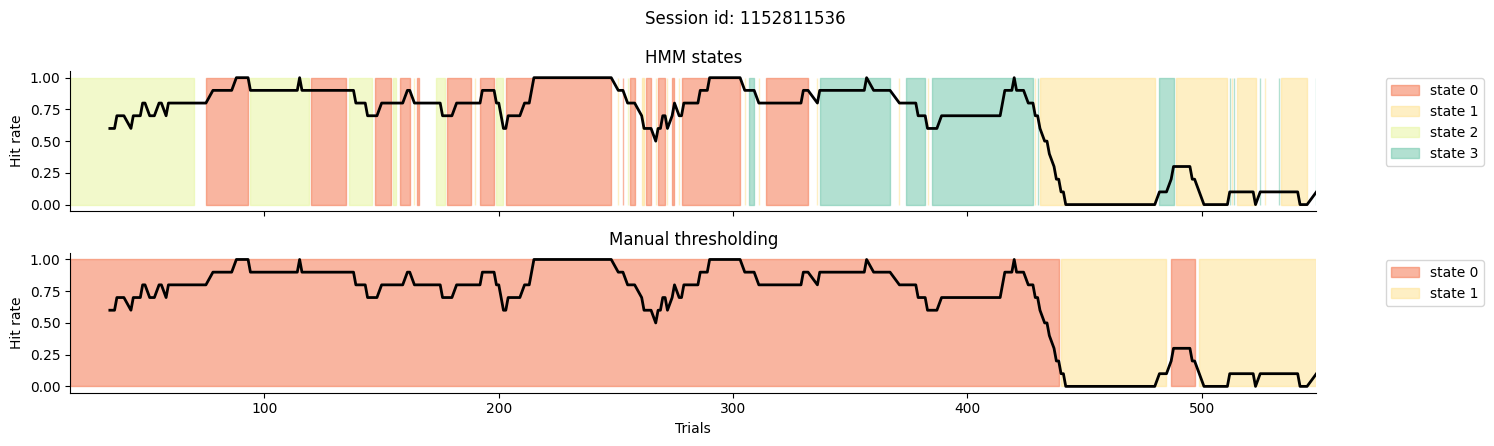

In [64]:
# Define state boundaries 
fig, ax = plt.subplots(2, 1, figsize=(15, 4.5), sharex=True)
hmm_states = most_likely_states
for state_id in range(best_num_states): 
    ax[0].fill_between(go_trials.index, 0, 1, where = hmm_states == state_id, alpha=0.5, color = cmap[state_id], ls = 'None', label = f'state {state_id}')
ax[0].plot(go_trials.index, hit_rate, color = 'k', lw = 2)

# from previous definition
for state_id in range(np.nanmax(states)+1): 
    ax[1].fill_between(go_trials.index, 0, 1, where = states == state_id, alpha=0.5, color = cmap[state_id], ls = 'None', label = f'state {state_id}')
ax[1].plot(go_trials.index, hit_rate, color = 'k', lw = 2)

# Formatting 
ax[0].set_title('HMM states')
ax[1].set_title('Manual thresholding')
ax[1].set_xlabel("Trials")

for j in range(2): 
    ax[j].set_ylabel('Hit rate')
    ax[j].set_xlim(go_trials.index[0], go_trials.index[-1])
    handles, labels = ax[j].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[j].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05, 1), fontsize = 10)

    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)

plt.suptitle(f'Session id: {session_id}')
plt.tight_layout()